# Bachelor Thesis - Impacts in viscoelastic foams
# Modelisation of the problem

We will consider different models for impacts in viscoelastic foams. We will compare their reactions to impacts against rigid solids, and then against a similar viscoelastic solid.

## Part 1: Considering Different Models

We will consider at first simple models for impacts in visocelastic foams. We can consider 4 different models, and analyse their responses to an impact. The first two will be the Kelvin-Voigt, and Maxwell Model, while the latter two will be the Maxwell and Kelvin-Voigt representations of the standard linear model.

### Maxwell Model

The Maxwell model is described by a damper and sprring mounted in series, as seen in the diagram below
![title](images/maxwell.png)
We can see that following a deformation, the damper element will not return to it's initial length, and therre is therefore an element of permanent deformation. We can therefore discount this model, as it clearly does not represent the situation wee are trying to model, that of a boxing glove.

### Kelvin-Voigt Model
The Kelvin-Voigt model is described by a damper and spring mounted in parallel to one another, as seen in the diagram below.
![title](images/kelvin-voigt.png)
We can see that unlike the Maxwell model, when the Kelvin-Voigt system is compressed and released, it will return to its initial size. This is representative of the system we are seeking to model, and can therefore be explored further.

### Standard Linear Solid Model
The standard linear solid model (SLSM) can be represented in one of two ways, however both of these ways overcome the inability of the basic Maxwell model to return to its initial size when unloaded. We will consider both models below.
#### Maxwell representation of the SLSM
The maxwell representation of the standard linear solid model is described as a spring in parallel with a basic Maxwell model (i.e. a spring and damper in series) as described in the diagram below.
![title](images/standard-maxwell.png)

#### Kelvin-Voigt representation of the SLSM
The Kelvin-Voigt representation of the standard linear solid model is described as a spring in series with a basic Kelvin-Voigt model (i.e. a spring and damper in parallel), as described in the diagram below.
![title](images/standard-kelvin-voigt.png)

We will therefore consider the latter three models, ignoring only the basic maxwell model.

## Part 2: Equations behind the Models
$\renewcommand{\eps}{\varepsilon}$
We will now seek to write the equations for each of these three models. We will write out the differential equations in full, and we will write them iteratively for a given time step up to a first order approximation, in order to implement them programatically. We will write as $k_i$ the spring constants, and $\eta_i$ the dmaping constants, with $\sigma = \frac{F}{A}$ the stress, and $\eps = \frac{\Delta L}{L}$ the strain, where $F$ is the force, $A$ the surface area, and $L$ the length.
### Kelvin-Voigt

Differential Equation: $\sigma = k\eps + \eta \dot{\eps}$

Iterative equation: $\sigma_{t+\delta t} = k \eps_t + \eta \dot{\eps}_t$

### Maxwell representation of the standard linear solid model

Differential Equation: $\sigma + \frac{\eta}{k_2}\dot{\sigma} = k_1\eps + \frac{\eta(k_1 + k_2)}{k_2}\dot{\eps}$

Iterative equation: $\sigma_{t+\delta t} = k_1\eps_t + \frac{\eta(k_1 + k_2)}{k_2}\dot{\eps}_t - \frac{\eta}{k_2}\dot{\sigma}_t$

$\dot{\sigma}_{t+\delta t} = \frac{k_2}{\eta}\left(k_1\eps_t + \frac{\eta(k_1 + k_2)}{k_2}\dot{\eps}_t - \sigma_t \right)$

### Kelvin-Voigt representation of the standard linear solid model

Differential Equation: $\sigma + \frac{\eta}{k_1+k_2}\dot{\sigma} = \frac{k_1k_2}{K-1+k_2}\eps + \frac{k_1\eta}{k_1+k2}\dot{\eps}$

Iterative equation: $\sigma_{t+\delta t} = \frac{k_1k_2}{k_1+k_2}\eps_t + \frac{k_1\eta_t}{k_1+k_2}\dot{\eps}_t - \frac{\eta}{k_1+k_2}\dot{\sigma}_t$

$\dot{\sigma}_{t+\delta t} = \frac{k_1+k_2}{\eta}\left(\frac{k_1k_2}{k_1+k_2}\eps_t + \frac{k_1\eta_t}{k_1+k_2}\dot{\eps}_t - \sigma_t \right)$

#### General remarks on iterative modelling

For all three cases, when treating the model iteratively, we will have

$\eps_{t+\delta t} = \eps_t + \delta t \dot{\eps}_t$

$\dot{\eps}_{t+\delta t} = \dot{\eps}_{t} + \delta t \ddot{\eps}_t$

$\ddot{\eps}_{t+\delta t} = \frac{A}{m}\sigma_{t+\delta t}$


## Part 3: Implementing the models - Impact case:
We are interested in the behaviour of the model immediately after an impact. We will consider the basic case of a visco-eelastic solid impacting a rigid surface with a velocity $v_0$ downwards, and driven by a force $F_0$. We therefore initialise $\dot{\eps}(t=0) = v_0$, and all other parameters are initialised to 0. The value used for $F_0$ is characteristic for a punch, which is around $80g \approx 800 \, N$


In [30]:
### Import Necessary packages
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt

### Initialise model parameters:
m = 0.4 # mass (approx. mass of a boxing glove)
k = 22000 # Single-spring constant (approx. for rubber foam)
eta = 800# single-damper constant
A = 0.01 # Surface
F_0 = 800 # Constant force applied

### Variable Initialisation
e = 0 # Initial strain
ev = 1 # Initial strain speed
ea = 0 # Initial strain acceleration
sig = 0 # Initial stress
sigv = ev*eta # Initial stress speed

### Kelvin-Voigt

![title](images/kelvin-voigt.png)

$\sigma_{t+\delta t} = k \eps_t + \eta \dot{\eps}_t$

In [31]:
def kelvin_voigt_iter(e,ev,ea,sig,dt):
    # Define iterative function for definining t+dt from point t according to kelvin-voigt model.
    signew = (k*e + eta*ev) if e>=0 else 0 # define force at t+dt from constitutive equation
    eanew = (A/m)*(F_0 - signew) # Define acceleration from force
    evnew = ev + dt*eanew # Define velocity from old velocity and acceleration
    enew = e + dt*evnew #Define strain from old strain and velocity
    return enew, evnew, eanew, signew
    

In [32]:
def kelvin_voigt(e_init,ev_init,ea_init,sig_init,dt,N):
    #Defines the full loop of kelvin voigt model, performing iteeratve step N times, with step dt.
    (e,ev,ea,sig) = (e_init,ev_init,ea_init,sig_init)
    (elist,evlist,ealist,siglist) = ([e],[ev],[ea],[sig])
    for i in range(N):
        (enew,evnew,eanew,signew) = kelvin_voigt_iter(e,ev,ea,sig,dt)
        elist.append(enew)
        evlist.append(evnew)
        ealist.append(eanew)
        siglist.append(signew)
        (e,ev,ea,sig) = (enew,evnew,eanew,signew)
    return elist,evlist,ealist,siglist

In [33]:
(el,evl,eal,sigl) = kelvin_voigt(e,ev,ea,sig,0.001,2000)

<IPython.core.display.Javascript object>


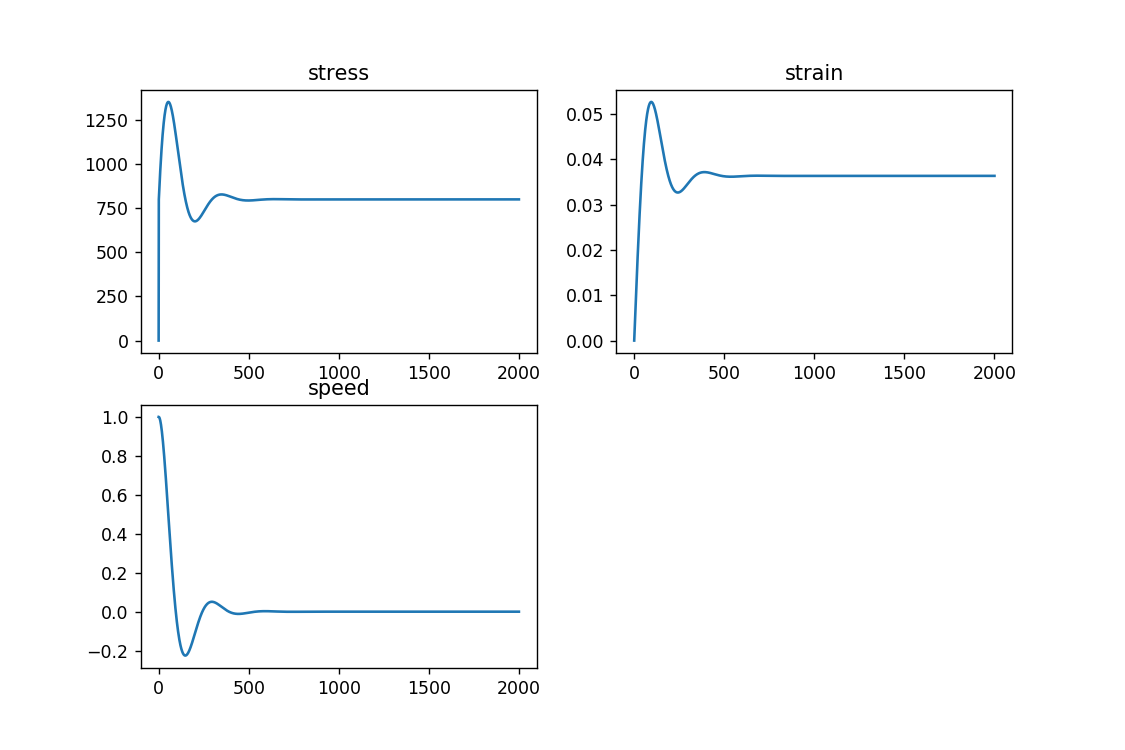

In [34]:
plt.figure(figsize=(9,6))
plt.subplot(221)
plt.title('stress')
plt.plot(sigl)
plt.subplot(222)
plt.title('strain')
plt.plot(el)
plt.subplot(223)
plt.title('speed')
plt.plot(evl)
plt.show()

### Standard Linear Solid Model - Maxwell Representation

![title](images/standard-maxwell.png)

$\sigma_{t+\delta t} = k_1\eps_t + \frac{\eta(k_1 + k_2)}{k_2}\dot{\eps}_t - \frac{\eta}{k_2}\dot{\sigma}_t$

$\dot{\sigma}_{t+\delta t} = \frac{k_2}{\eta}\left(k_1\eps_t + \frac{\eta(k_1 + k_2)}{k_2}\dot{\eps}_t - \sigma_t \right)$

In [77]:
### Initialise Parameters
k1 = 12000 # Double-spring constant 1
k2 = 20000 # Double-spring constant 2
eta = 800 # Damping constant

In [78]:
def SLSM_maxwell_iter(e,ev,ea,sig,sigv,dt):
    # Define iterative function for definining t+dt from point t according to SLSM-Maxwell model.
    sigvnew = (k2/eta)*(k1*e + ev*(eta*(k1+k2))/k2 - sig) if e>=0 else 0 # define force speed at t+dt from constitutive equation
    signew =  sig + dt*sigvnew if e>=0 else 0 # define force at t+dt from constitutive equation k1*e + ev*(eta*(k1+k2))/k2 - (eta/k2)*sigv
    eanew = (A/m)*(F_0 - signew) # Define acceleration from force
    evnew = ev + dt*eanew # Define velocity from old velocity and acceleration
    enew = e + dt*evnew #Define strain from old strain and velocity
    return enew, evnew, eanew, signew, sigvnew
    

In [79]:
def SLSM_maxwell(e_init,ev_init,ea_init,sig_init,sigv_init,dt,N):
    #Defines the full loop of SLSM-maxwell model, performing iteeratve step N times, with step dt.
    (e,ev,ea,sig,sigv) = (e_init,ev_init,ea_init,sig_init,sigv_init)
    (elist,evlist,ealist,siglist,sigvlist) = ([e],[ev],[ea],[sig],[sigv])
    for i in range(N):
        (enew,evnew,eanew,signew,sigvnew) = SLSM_maxwell_iter(e,ev,ea,sig,sigv,dt)
        elist.append(enew)
        evlist.append(evnew)
        ealist.append(eanew)
        siglist.append(signew)
        sigvlist.append(sigvnew)
        (e,ev,ea,sig,sigv) = (enew,evnew,eanew,signew,sigvnew)
    return elist,evlist,ealist,siglist,sigvlist

In [80]:
(el,evl,eal,sigl,sigvl) = SLSM_maxwell(e,ev,ea,sig,sigv,0.001,2000)

<IPython.core.display.Javascript object>


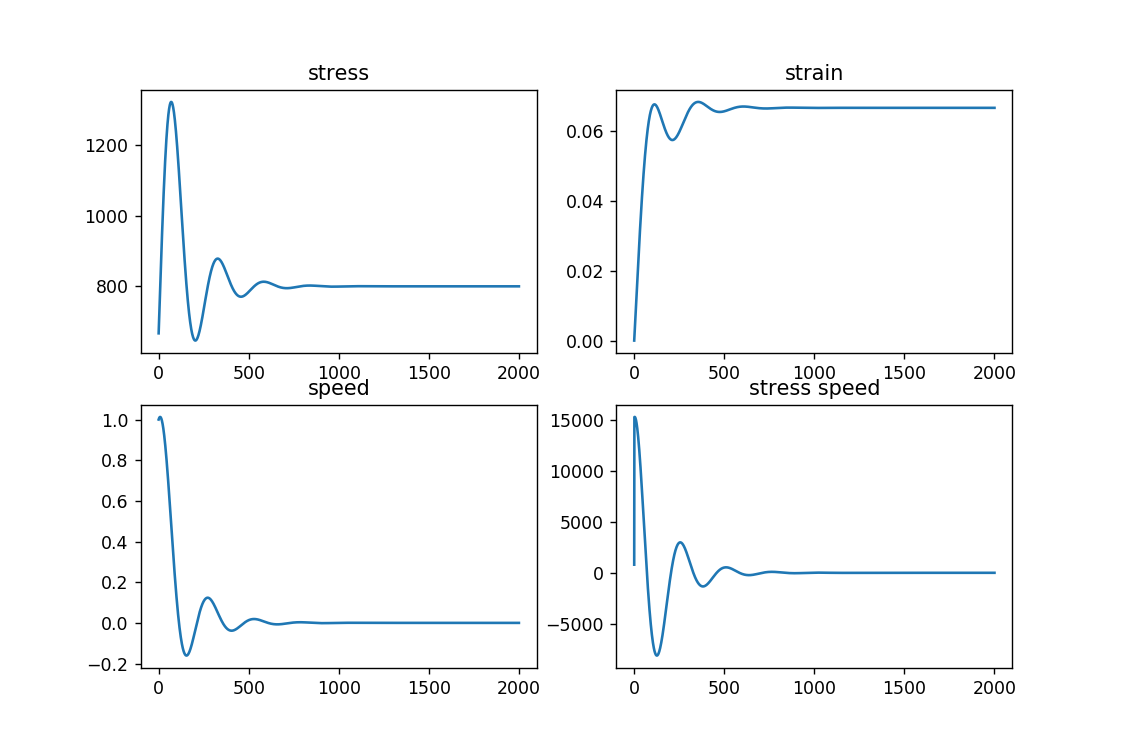

In [81]:
plt.figure(figsize=(9,6))
plt.subplot(221)
plt.title('stress')
plt.plot(sigl)
plt.subplot(222)
plt.title('strain')
plt.plot(el)
plt.subplot(223)
plt.title('speed')
plt.plot(evl)
plt.subplot(224)
plt.title('stress speed')
plt.plot(sigvl)
plt.show()

### Standard Linear Solid Model - Kelvin-Voigt Representation

![title](images/standard-kelvin-voigt.png)

$\sigma_{t+\delta t} = \frac{k_1k_2}{k_1+k_2}\eps_t + \frac{k_1\eta_t}{k_1+k_2}\dot{\eps}_t - \frac{\eta}{k_1+k_2}\dot{\sigma}_t$

$\dot{\sigma}_{t+\delta t} = \frac{k_1+k_2}{\eta}\left(\frac{k_1k_2}{k_1+k_2}\eps_t + \frac{k_1\eta_t}{k_1+k_2}\dot{\eps}_t - \sigma_t \right)$

In [87]:
### Initialise Parameters
k1 = 60000 # Double-spring constant 1
k2 = 30000 # Double-spring constant 2
eta = 2000 # Damping constant
sig = e*k1*k2/(k1+k2) + ev*(eta*k1)/(k1+k2)

In [88]:
def SLSM_kelvin_voigt_iter(e,ev,ea,sig,sigv,dt):
    # Define iterative function for definining t+dt from point t according to SLSM-kelvin-voigt model.
    sigvnew = (k1+k2/eta)*(e*k1*k2/(k1+k2) + ev*(eta*k1)/(k1+k2) - sig) if e>=0 else 0 # define force speed at t+dt from constitutive equation
    signew =  sig + dt*sigvnew if e>=0 else 0 # define force at t+dt from constitutive equation
    # signew = e*k1*k2/(k1+k2) + ev*k1*eta/(k1+k2) -  eta*sigv/(k1+k2) if e>=0 else 0
    # sigvnew = (k1+k2/eta)*(e*k1*k2/(k1+k2) + ev*(eta*k1)/(k1+k2) - sig)
    eanew = (A/m)*(F_0 - signew) # Define acceleration from force
    evnew = ev + dt*eanew # Define velocity from old velocity and acceleration
    enew = e + dt*evnew #Define strain from old strain and velocity
    return enew, evnew, eanew, signew, sigvnew

In [89]:
def SLSM_kelvin_voigt(e_init,ev_init,ea_init,sig_init,sigv_init,dt,N):
    #Defines the full loop of SLSM-kelvin-voigt model, performing iteratve step N times, with step dt.
    (e,ev,ea,sig,sigv) = (e_init,ev_init,ea_init,sig_init,sigv_init)
    (elist,evlist,ealist,siglist,sigvlist) = ([e],[ev],[ea],[sig],[sigv])
    for i in range(N):
        (enew,evnew,eanew,signew,sigvnew) = SLSM_kelvin_voigt_iter(e,ev,ea,sig,sigv,dt)
        elist.append(enew)
        evlist.append(evnew)
        ealist.append(eanew)
        siglist.append(signew)
        sigvlist.append(sigvnew)
        (e,ev,ea,sig,sigv) = (enew,evnew,eanew,signew,sigvnew)
    return elist,evlist,ealist,siglist,sigvlist

In [90]:
(el,evl,eal,sigl,sigvl) = SLSM_kelvin_voigt(e,ev,ea,sig,sigv,0.00001,100000)

<IPython.core.display.Javascript object>


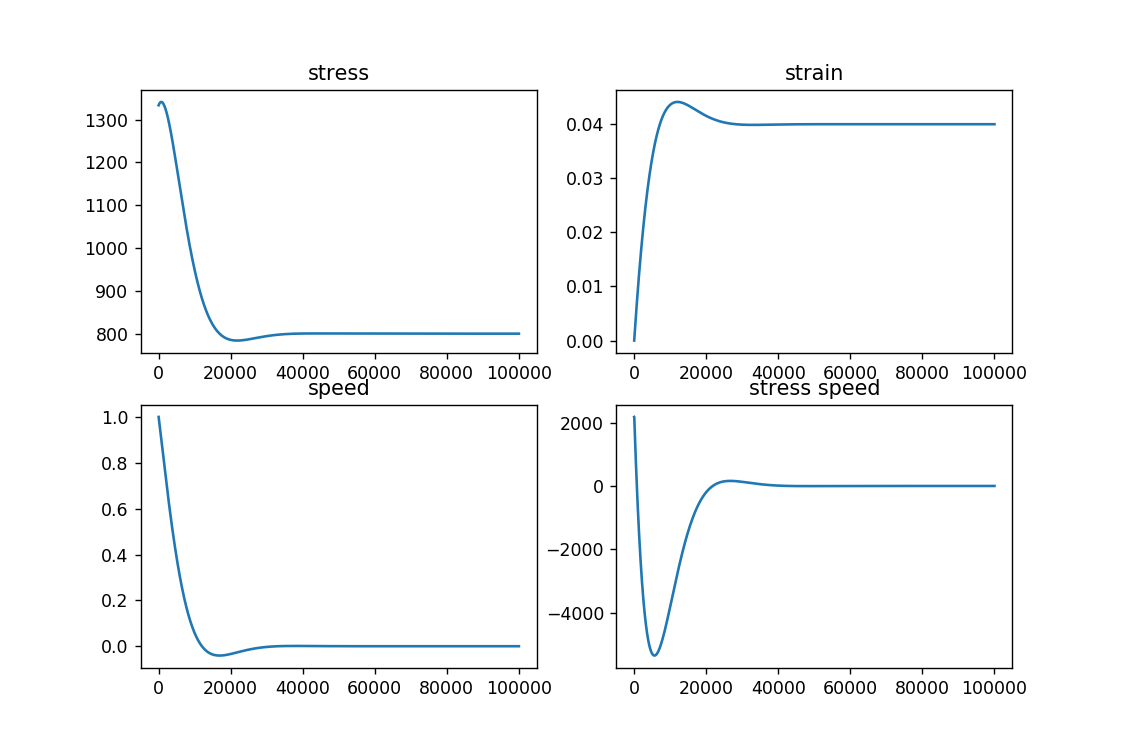

In [91]:
plt.figure(figsize=(9,6))
plt.subplot(221)
plt.title('stress')
plt.plot(sigl)
plt.subplot(222)
plt.title('strain')
plt.plot(el)
plt.subplot(223)
plt.title('speed')
plt.plot(evl)
plt.subplot(224)
plt.title('stress speed')
i=15
sigvl[0:i]=[sigvl[i]]*i
plt.plot(sigvl)
plt.show()

## Part 4: Analysing and Comparing the models

Due to the fact that we have different input parameters for each model, it is very difficult to compare them $\textit{ceteris paribus}$, however, we can consider each of them individually, and understand their dependence on theeir various inputs.

### Kelvin - Voigt

We will start from an arbitrary $\textit{reference}$ configuration, $(k = 22000 \, N/m,\, \eta = 800 \, Ns/m)$, and vary both parameters independently.

In [96]:
## Comparison at constant eta = 800
eta = 800
### Variable Initialisation
e = 0 # Initial strain
ev = 1 # Initial strain speed
ea = 0 # Initial strain acceleration
sig = 0 # Initial stress
k = 10000
(el1,evl1,eal1,sigl1) = kelvin_voigt(e,ev,ea,sig,0.001,1000)
k = 16000
(el2,evl2,eal2,sigl2) = kelvin_voigt(e,ev,ea,sig,0.001,1000)
k = 22000
(el3,evl3,eal3,sigl3) = kelvin_voigt(e,ev,ea,sig,0.001,1000)
k = 28000
(el4,evl4,eal4,sigl4) = kelvin_voigt(e,ev,ea,sig,0.001,1000)
k = 34000
(el5,evl5,eal5,sigl5) = kelvin_voigt(e,ev,ea,sig,0.001,1000)

<IPython.core.display.Javascript object>


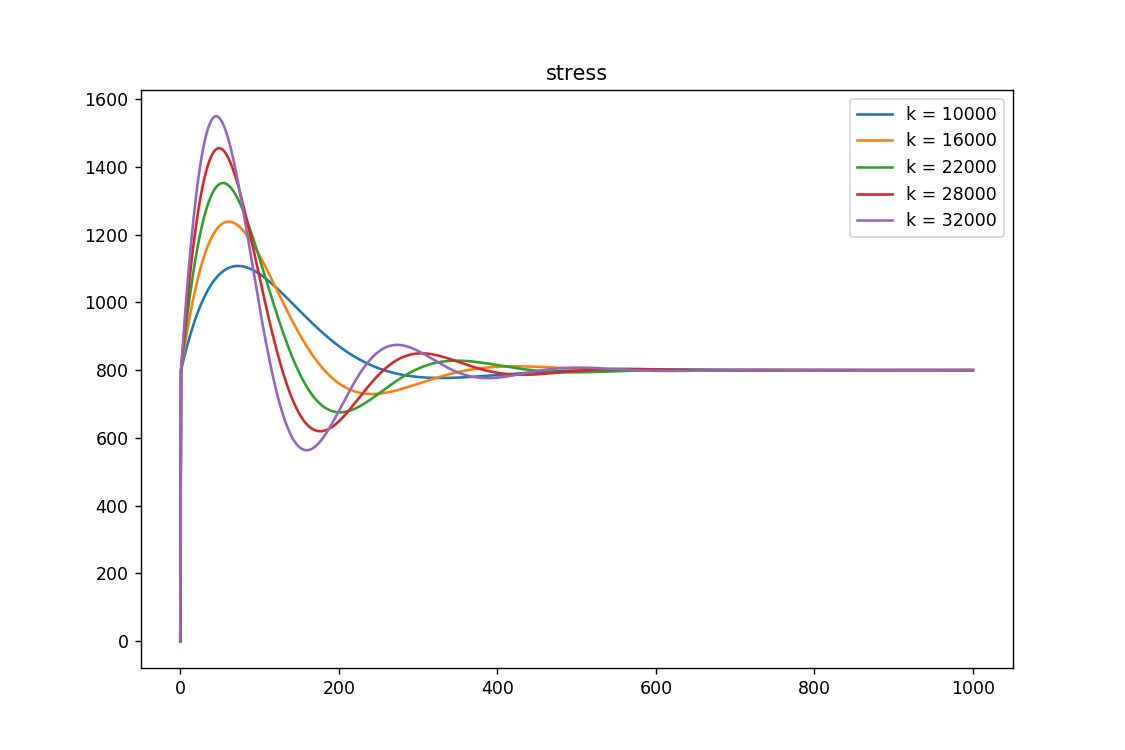

In [99]:
plt.figure(figsize=(9,6))
plt.title('stress')
plt.plot(sigl1 , label = 'k = 10000')
plt.plot(sigl2 , label = 'k = 16000')
plt.plot(sigl3 , label = 'k = 22000')
plt.plot(sigl4 , label = 'k = 28000')
plt.plot(sigl5 , label = 'k = 32000')
plt.legend()

#### Analysis
We can see that a higher spring constant corresponds to a higher peak force, a shorter impact time, and more oscillations.

In [109]:
## Comparison at constant k = 22000
k = 22000
### Variable Initialisation
e = 0 # Initial strain
ev = 1 # Initial strain speed
ea = 0 # Initial strain acceleration
sig = 0 # Initial stress
eta = 100
(el1,evl1,eal1,sigl1) = kelvin_voigt(e,ev,ea,sig,0.001,1000)
eta = 400
(el2,evl2,eal2,sigl2) = kelvin_voigt(e,ev,ea,sig,0.001,1000)
eta = 800
(el3,evl3,eal3,sigl3) = kelvin_voigt(e,ev,ea,sig,0.001,1000)
eta = 1200
(el4,evl4,eal4,sigl4) = kelvin_voigt(e,ev,ea,sig,0.001,1000)
eta = 1600
(el5,evl5,eal5,sigl5) = kelvin_voigt(e,ev,ea,sig,0.001,1000)

<IPython.core.display.Javascript object>


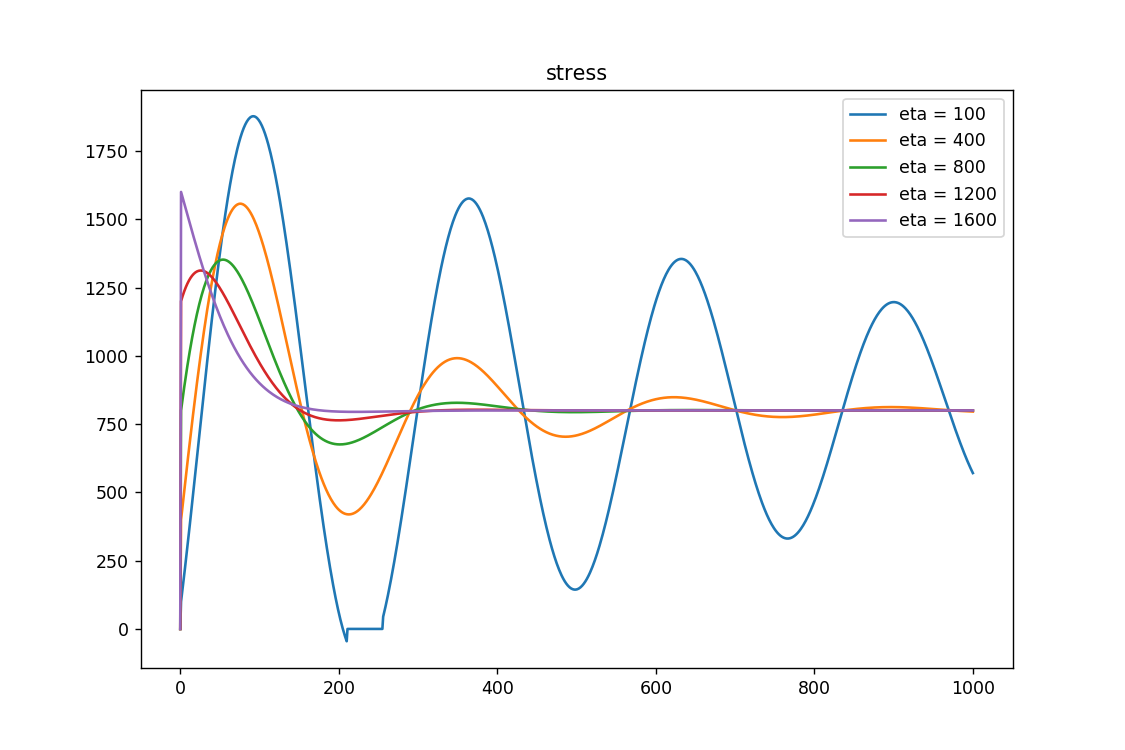

In [110]:
plt.figure(figsize=(9,6))
plt.title('stress')
plt.plot(sigl1 , label = 'eta = 100')
plt.plot(sigl2 , label = 'eta = 400')
plt.plot(sigl3 , label = 'eta = 800')
plt.plot(sigl4 , label = 'eta = 1200')
plt.plot(sigl5 , label = 'eta = 1600')
b = plt.legend()

#### Analysis

We can see that an increasing damping factor corresponds to a reduction of oscillations, a reduction in peak force, and a reduction in impact time.

### References

https://en.wikipedia.org/wiki/Maxwell_material 

https://en.wikipedia.org/wiki/Kelvin-Voigt_material 

https://en.wikipedia.org/wiki/Standard_linear_solid_model 